<div style="text-align: center;">

# MACHINE LEARNING PROJECT
## Deliverable #2

**<h3 align="center">CARS 4 YOU</h3>**

<span style="font-size: 24px;">Master in Data Science and Advanced Analytics</span>  
<span style="font-size: 24px;">NOVA Information Management School</span>  
<span style="font-size: 20px;"><i>Group 34</i></span>  
<span style="font-size: 20px;">Fall/Spring Semester 2025-2026</span>

</div>

---

**Carolina Luz** | 20250409 | [20250409@novaims.unl.pt](mailto:20250409@novaims.unl.pt) <br>
**Margarida Quintino** | 20250411 | [20250411@novaims.unl.pt](mailto:20250411@novaims.unl.pt) <br>
**Pedro Castro** | 20250467 | [20250467@novaims.unl.pt](mailto:20250467@novaims.unl.pt)  <br>
**Pedro Carrasqueira** | 20250488 | [20250488@novaims.unl.pt](mailto:20250488@novaims.unl.pt)  


## 1. Project Setup

This notebook functions as the Production Modeling Pipeline for the Cars 4 You price prediction project. Following the Exploratory Data Analysis (EDA) conducted in *notebook c/ EDA*, this environment is engineered to execute a rigorous, leak-proof optimization workflow.

The objective of this section is to initialize a stable computational environment. This involves importing the necessary architectural components from scikit-learn, configuring global reproducibility settings, and ingesting the raw data.

### 1.1. Library imports

We import libraries in a hierarchical manner:

* **Pipeline Architecture:** Components like Pipeline and ColumnTransformer are loaded to construct the processing "factory".

* **Model Selection:** RandomizedSearchCV and KFold are loaded to serve as the optimization engine and "validation judge".

* **Algorithms:** We import a diverse set of regressors (Linear, Tree-based, and Ensemble) to define our hyperparameter search space.

In [1]:
# Standard Data Manipulation & Mathematics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

# Scikit-Learn: Pipeline & Preprocessing Architecture
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_regression

# Scikit-Learn: Model Selection & Evaluation
from sklearn.model_selection import RandomizedSearchCV, KFold
# Updated to include all necessary metrics
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Scikit-Learn: Algorithms (Regressors)
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Statistical Distributions (for Random Search)
from scipy.stats import randint, uniform

### 1.2. Global configuration

A global random seed (RSEED = 42) is enforced across numpy and pandas. This guarantees that all stochastic operations (such as Cross-Validation splits) are deterministic and reproducible.

In [2]:
#Suppress warnings to maintain a clean execution log during iterative training
warnings.filterwarnings('ignore')

# Configure Pandas display options for easier dataframe inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Define Global Random Seed for Reproducibility
# This ensures that all random operations (splits, initializations) are constant.
RSEED = 42
np.random.seed(RSEED)

### 1.3. Data ingestion, Target separation and transformation

During the Exploratory Data Analysis (EDA) phase, we identified a significant right-skew in the target variable (price). To address this, we apply a Log-Transformation (np.log1p) to the target variable immediately upon loading the dataset. This transformation is a strategic global decision: it is critical for stabilizing variance and approximating a normal distribution (thereby satisfying the homoscedasticity assumption required by our linear estimators), while remaining neutral for the tree-based models (which rely on feature order rather than absolute magnitude).

In [3]:
# Load the training and testing datasets from the working directory
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Isolate the Target Variable ('price') and Features (X)
# We use the suffix '_full' to indicate this is the complete training set
# prior to any cross-validation splitting.
X_train_full = train_df.drop(columns=['price'])
y_train_full = train_df['price']

#Apply Log-Transformation to Target
# Predicting log(price) stabilizes variance and improves linear model performance.
y_train_log = np.log1p(y_train_full)

## 2. Deterministic Data Cleaning and Pre-split Processing

In this phase, we execute the stateless data transformations listed below. Unlike statistical imputation (which relies on the mean or median of a specific dataset split), these operations rely solely on domain logic and hard rules.

* **Categorical Standardization:**
To eliminate high-cardinality noise caused by data entry inconsistencies, we apply strict dictionary mappings to standardize categorical entities (e.g., correcting "ord" to "ford", "vw" to "volkswagen"). Concurrently, we normalize all string inputs to lowercase and strip whitespace, ensuring that minor formatting variations do not result in duplicate feature categories.

* **Logical Inconsistencies Correction:** 
We identify and rectify logical impossibilities, specifically targeting negative values for mileage, tax, mpg, and engineSize. These entries are flagged as data corruption and converted to NaN, allowing the downstream pipeline to handle them via statistical imputation rather than training on corrupt data.

* **Temporal Logic Validation:** 
Given that the dataset represents a snapshot from 2020, any vehicle listed with a registration year of 2021 or later is treated as a chronological error. These values are converted to NaN to prevent the model from learning patterns based on "future" dates that contradict the dataset's collection context.

* **Discrete Validity Check:** 
We enforce strict integer constraints on the previousOwners column, as partial ownership is logically impossible. Fractional values (e.g., 1.5) are identified as data parsing errors and converted to missing values (NaN) to preserve the discrete nature of the variable.

By performing these deterministic cleanups prior to Cross-Validation, we significantly reduce computational overhead. The pipeline does not need to re-learn how to fix a typo 500 times; it simply receives clean, standardized strings.

In [4]:

# 1. Standardization Mappings

# These dictionaries map various typo/abbreviation permutations to the standard class.
# Derived from the EDA notebook.

brand_map = {
    'for': 'ford', 'ord': 'ford', 'or': 'ford',
    'ercedes': 'mercedes', 'mercede': 'mercedes', 'ercede': 'mercedes',
    'vw': 'volkswagen', 'v': 'volkswagen', 'w': 'volkswagen',
    'ope': 'opel', 'pel': 'opel', 'pe': 'opel',
    'mw': 'bmw', 'bm': 'bmw',
    'aud': 'audi', 'udi': 'audi', 'ud': 'audi',
    'oyota': 'toyota', 'toyot': 'toyota',
    'koda': 'skoda', 'skod': 'skoda', 'kod': 'skoda',
    'yundai': 'hyundai', 'hyunda': 'hyundai', 'yunda': 'hyundai'
}

transmission_map = {
    'anual': 'manual', 'manua': 'manual', 'anua': 'manual',
    'semi-aut': 'semi-auto', 'emi-aut': 'semi-auto', 'emi-auto': 'semi-auto',
    'automati': 'automatic', 'utomatic': 'automatic', 'utomati': 'automatic',
    'nknown': 'unknown', 'nknow': 'unknown', 'unknow': 'unknown'
}

fueltype_map = {
    'etrol': 'petrol', 'petro': 'petrol', 'etro': 'petrol',
    'iesel': 'diesel', 'diese': 'diesel', 'iese': 'diesel',
    'ybri': 'hybrid', 'hybri': 'hybrid', 'ybrid': 'hybrid',
    'ther': 'other', 'othe': 'other'
}

model_map = {
    'tigua': 'tiguan', 't-ro': 't-roc', 'tiguan allspac': 'tiguan allspace',
    'astr': 'astra', 'fiest': 'fiesta', 'insigni': 'insignia',
    'octavi': 'octavia', 'monde': 'mondeo', 'passa': 'passat',
    'edg': 'edge', 'mokk': 'mokka', 'arteo': 'arteon',
    'aur': 'auris', 'fabi': 'fabia', 'ayg': 'aygo',
    'gol': 'golf', 'coroll': 'corolla', 'zafir': 'zafira',
    'c-ma': 'c-max', 'grand c-ma': 'grand c-max', 'b-ma': 'b-max',
    'yeti outdoo': 'yeti outdoor', 'grand tourneo connec': 'grand tourneo connect'
}

# 2 Deterministic Cleaning Function

def clean_features(df):
    """
    Applies row-level cleaning rules to standardization strings and handle logical errors.
    
    Args:
        df (pd.DataFrame): The raw input dataframe.
        
    Returns:
        pd.DataFrame: The cleaned dataframe with NaNs in place of invalid values.
    """
    df = df.copy()
    
    # 2.1 String Standardization
    # Convert to lowercase and strip whitespace to ensure mapping matches
    for col, mapping in [('Brand', brand_map), ('transmission', transmission_map), 
                         ('fuelType', fueltype_map), ('model', model_map)]:
        if col in df.columns:
            df[col] = df[col].str.lower().str.strip()
            df[col] = df[col].replace(mapping)

    # 2.2 Negative Value Handling
    # Physical quantities cannot be negative. We convert them to NaN (Missing).
    cols_to_check = ['mileage', 'tax', 'mpg', 'engineSize', 'previousOwners']
    for col in cols_to_check:
        if col in df.columns:
            # Mask replaces values where condition is True with NaN
            df[col] = df[col].mask(df[col] < 0, np.nan)

    # 2.3 Year & Date Logic
    # The database snapshot is from 2020. Any car with year > 2020 is a data error.
    if 'year' in df.columns:
        df['year'] = pd.to_numeric(df['year'], errors='coerce').round()
        df.loc[df['year'] > 2020, 'year'] = np.nan
        df['year'] = df['year'].astype('Int64') # Allows NaNs in integer column

    # 2.4 Discrete Value Logic
    # Previous Owners must be whole numbers.
    if 'previousOwners' in df.columns:
        df.loc[df['previousOwners'] % 1 != 0, 'previousOwners'] = np.nan
        df['previousOwners'] = df['previousOwners'].astype('float')

    return df


# 3. Execution
# Apply cleaning to the Training Feature Matrix
X_train_clean = clean_features(X_train_full)

# Apply cleaning to the Test Set (Holdout)
# Note: We do NOT touch the Test Set again until the final evaluation
X_test_clean = clean_features(test_df)


## 3. Transformer Implementation and Feature Engineering

In this phase, we constructed the specific "logic blocks" (Transformers) that process data within our automated pipeline.

* **Feature Engineering Wrapper:** 
We implemented a custom *engineer_features_wrapper* to dynamically generate our engineered features: `age` (to account for car depreciation) and `mileage_per_year` (to account for car usage intensity). 
By wrapping this logic in a FunctionTransformer, we ensure these features are created on-the-fly for every fold of the Cross-Validation, preserving the automated workflow.

* **Variable Grouping:** 
We explicitly separated our features into Numeric and Categorical. Crucially, we included the new features (`age` and `mileage_per_year`) in the numeric list, anticipating their creation by the previous step. We also assigned `previousOwners` to the numeric list to treat it as a continuous ordinal variable, allowing for median imputation.

* **Numeric Transformation Strategy:** 
For continuous variables, we adopted a robust two-step approach. First, we use Median Imputation to fill missing values, as the median is resistant to the right-skewed price distribution we identified in the EDA. Second, we apply Robust Scaling (based on the Interquartile Range) rather than Standard Scaling. This ensures that the extreme outliers common in luxury vehicle prices do not distort the performance of our linear models (Lasso/Ridge).

* **Categorical Transformation Strategy:** 
For qualitative variables, we prioritized safety and stability. We fill missing values with a constant "unknown" label to preserve the information that data is missing. Subsequently, we apply One-Hot Encoding with the parameter handle_unknown='ignore'. This prevents the model from crashing in production if the Test Set contains a rare brand or model that was never seen during training.

In [ ]:
# 1 Feature Engineering Wrapper
def engineer_features_wrapper(X):
    """
    Generates domain-specific features 'age' and 'mileage_per_year'.
    Includes Type-Casting fix to prevent pd.NA boolean errors.
    """
    X = X.copy()
    
    # Convert nullable types to standard floats
    # This converts pd.NA (which crashes np.where) into np.nan (which is safe)
    if 'year' in X.columns:
        X['year'] = X['year'].astype(float)
    if 'mileage' in X.columns:
        X['mileage'] = X['mileage'].astype(float)
    
    # 1. Create Age (Reference Year: 2020)
    X['age'] = (2020 - X['year']).clip(lower=0)
    
    # 2. Create Usage Intensity
    # np.where works safely now because inputs are floats
    X['mileage_per_year'] = np.where(
        X['age'] > 0, 
        X['mileage'] / X['age'], 
        X['mileage']
    )
    
    # Cleanup infinite values
    X['mileage_per_year'] = X['mileage_per_year'].replace([np.inf, -np.inf], 0)
    
    return X

# Convert to Scikit-Learn Transformer
feat_engineer = FunctionTransformer(engineer_features_wrapper, validate=False)


# 2. Variable Grouping
numeric_features = [
    'year', 'mileage', 'tax', 'mpg', 'engineSize', 
    'paintQuality%', 'age', 'mileage_per_year'
]

categorical_features = [
    'Brand', 'model', 'transmission', 'fuelType'
]

# Add previousOwners to numeric path
numeric_features.append('previousOwners')

# 3. Numeric Transformation Logic
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# 4. Categorical Transformation Logic
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

## 4. Pipeline Architecture Construction

In this phase, we combine the individual components defined in Section 3 into a single pipeline. This architecture relies on two structural patterns: Parallel Processing (for column transformations) and Sequential Processing (for the overall workflow).

### 4.1. Column Composition (Parallel Processing)

We use a ColumnTransformer to split the dataset into two streams.

* **The Numeric Stream:** Applies imputation and robust scaling. this stream is configured to process the `age` and `mileage_per_year` columns, anticipating that the upstream feature engineer will create them before this step runs.

* **The Categorical Stream:** Executes Constant Imputation (filling 'unknown') followed by One-Hot Encoding.

* **Cleanup:** We set remainder='drop' to ensure that any original columns not explicitly targeted for processing are removed, keeping the dataset clean.

In [6]:
# 1 Column Composition

# The ColumnTransformer applies specific transformations to their respective column groups in parallel. 
# We include 'age' and 'mileage_per_year' in 'numeric_features' (defined in Section 3) because the upstream Feature Engineer will have created them by the time data reaches this step.

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drop any original columns not explicitly listed to keep data clean
)

### 4.2. Master Pipeline Assembly (Sequential Processing)

We construct the final model_pipeline, which enforces a strict "End-to-End" execution order to prevent data leakage.

* **Step 1 - Feature Engineering:** This runs first. It expands the dataset by calculating the new features (`age`, `usage`) on the fly.

* **Step 2 - Preprocessing:** The ColumnTransformer receives the expanded dataset from Step 1. It imputes missing values and scales the data to prepare it for modeling.

* **Step 3 - Feature Selection:** We use SelectKBest (using the F-value statistic) to score all features and retain only the most predictive ones, filtering out noise.

* **Step 4 - Model Placeholder:** We place a default estimator (Lasso) at the end. This acts as a placeholder slot that the Random Search will dynamically "hot-swap" with our candidate algorithms during the experiment.

In [7]:
# 2. Master Pipeline Assembly
# This is the final "End-to-End" machine. 
# It chains the logic: Engineer -> Preprocess -> Select -> Predict.

model_pipeline = Pipeline(steps=[
    # Step 1: Feature Engineering
    # This must run FIRST to create the columns 'age' and 'mileage_per_year' so that Step 2 (preprocessor) can find them.
    ('engineer', feat_engineer),
    
    # Step 2: Preprocessing
    # Imputes missing values and scales/encodes features.
    ('preprocessor', preprocessor),
    
    # Step 3: Feature Selection
    # We use f_regression (ANOVA) to score feature importance.
    # The number of features to keep ('k') is a hyperparameter we will tune later.
    ('selector', SelectKBest(score_func=f_regression)),
    
    # Step 4: Model Placeholder
    # We insert a dummy estimator (Lasso) here. 
    # The RandomizedSearchCV will 'hot-swap' this for actual candidates during the experiment.
    ('regressor', Lasso(random_state=RSEED))
])

## 5. Definition of Hyperparameter Search Space

In this phase, we formally define the "Search Menu" for our experiment. Rather than optimizing a single model type, we configure the RandomizedSearchCV engine to explore a diverse portfolio of five distinct algorithms simultaneously. 

We achieve this by creating a list of dictionaries, where each dictionary represents a specific Candidate Algorithm and defines the probability distributions for its unique hyperparameters. 
During execution, the search engine selects a dictionary at random, "hot-swaps" that specific estimator into the pipeline's placeholder slot, and tests a random combination of parameters defined within that configuration.

In [8]:

# 1 Parameter Grid Definition
# The 'param_distributions' is a list of dictionaries. 
# The RandomizedSearchCV picks one dictionary at random, swaps the 'regressor' into the pipeline, and samples parameters from the corresponding distributions.

param_distributions = [
    
    # Candidate 1: Lasso Regression (L1 Regularization)
    # Theory: Adds absolute-value penalty. Can reduce coefficients to zero (Feature Selection).
    {
        'regressor': [Lasso(random_state=RSEED)],
        'regressor__alpha': uniform(0.001, 10),  # Continuous distribution [0.001, 10.001]
        'selector__k': [10, 20, 30, 'all']       # Test strictly filtered feature sets
    },

    # Candidate 2: Ridge Regression (L2 Regularization)
    # Theory: Adds squared-value penalty. Shrinks coefficients but keeps them non-zero.
    # Better for handling multicollinearity (e.g., Year vs Age).
    {
        'regressor': [Ridge(random_state=RSEED)],
        'regressor__alpha': uniform(0.1, 50),    # Ridge typically requires higher alpha
        'selector__k': ['all']                   # Ridge handles all features well; no selection needed
    },

    # Candidate 3: Decision Tree Regressor
    # Theory: Single non-linear tree. Prone to overfitting, so we strictly limit depth.
    {
        'regressor': [DecisionTreeRegressor(random_state=RSEED)],
        'regressor__max_depth': [5, 10, 20, None],      # None = Infinite depth (High Variance)
        'regressor__min_samples_leaf': randint(1, 10),  # Minimum samples to create a leaf
        'selector__k': ['all']
    },

    # Candidate 4: Random Forest Regressor (Bagging)
    # Theory: Parallel ensemble of independent trees. Reduces variance via averaging.
    {
        'regressor': [RandomForestRegressor(random_state=RSEED)],
        'regressor__n_estimators': randint(50, 200),    # Number of trees in the forest
        'regressor__max_depth': [10, 20, None],         # Depth of individual trees
        'selector__k': ['all']                          # Forests perform internal feature selection
    },

    # Candidate 5: Gradient Boosting Regressor (Boosting)
    # Theory: Sequential ensemble where Tree N fixes errors of Tree N-1.
    # We keep depth low (Weak Learners) to prevent overfitting.
    {
        'regressor': [GradientBoostingRegressor(random_state=RSEED)],
        'regressor__n_estimators': randint(50, 200),
        'regressor__learning_rate': uniform(0.01, 0.2), # Step size for gradient descent
        'regressor__max_depth': [3, 4, 5],              # Shallow trees work best for boosting
        'selector__k': ['all']
    }
]

Our selection strategy balances Interpretability vs. Complexity and Bias vs. Variance, ensuring a comprehensive evaluation of the problem space.

#### 1. Linear Models: Lasso & Ridge

We employ Lasso and Ridge as strong baselines given the expected linear relationship between the predictors and the log-transformed target.

* **Lasso Regression:** 
Utilized for its ability to perform embedded feature selection. With high-cardinality categorical features (like specific car models), Lasso can zero out coefficients for irrelevant rare cars, effectively performing "automated pruning."

* **Ridge Regression:**
Specifically selected to handle the Multicollinearity introduced during feature engineering (e.g., the perfect correlation between Year and Age). Ridge handles this redundant information gracefully by shrinking coefficients rather than breaking, and we generally allow it to utilize all features (k='all').


#### 2. Non-Linear Baseline: Decision Tree

A single Decision Tree is utilized to capture non-linear "step functions" in price depreciation, such as sharp value drops when a new model version is released or when mileage crosses a psychological threshold (e.g., 100k miles). We strictly tune max_depth to prevent the tree from simply memorizing the training data, providing a critical benchmark for non-linear performance.


#### 3. Ensemble Methods: Random Forest & Gradient Boosting

* **Random Forest (Bagging):** Selected as the "low-variance" candidate. By averaging hundreds of independent trees, it is highly resistant to noise and overfitting, making it a robust estimator for mixed numeric/categorical data without requiring extensive fine-tuning.

* **Gradient Boosting (Boosting):** Selected as the "low-bias" candidate to maximize predictive accuracy. By building trees sequentially to correct previous errors, it captures complex, high-order interactions (e.g., how a Mercedes retains value differently than a Ford) that simpler models often miss.

## 6. Model Optimization via Randomized Cross-Validation

In this phase, we initiate the automated search engine using RandomizedSearchCV. This approach allows us to efficiently explore the hyperparameter space defined in Section 5 without the prohibitive computational cost of a full Grid Search. 

We configure a computational budget of 100 iterations (n_iter=100), ensuring that each of the five candidate algorithms receives approximately 20 independent trials to identify its optimal settings. 
To expedite this computationally intensive process, we enable full parallelization (n_jobs=-1): by utilizing all available CPU cores, we train multiple cross-validation folds simultaneously, significantly reducing the total time required for the experiment.

For our optimization metric, we select Root Mean Squared Error (RMSE), as our primary objective is strict error minimization. However, scikit-learn’s optimization architecture is hard-coded for maximization, operating under the default assumption that higher scores (like Accuracy) are superior. To reconcile this with our minimization goal, we utilize Negative RMSE. By inverting the sign of the error, we align the software's maximization logic with our objective: maximizing a negative score towards zero effectively minimizes the absolute magnitude of the prediction error.

Additionally, we employ 5-Fold Cross-Validation as the strategic optimum between statistical precision and computational efficiency. 
With a budget of 100 iterations, a 5-fold split results in 500 total model fits. Increasing this to 10-fold would double the workload to 1,000 fits, drastically increasing runtime for complex algorithms like Random Forest without yielding significant performance gains.

Finally, we run .fit() using the clean training set and the log-transformed target. Most importantly, the raw data enters the pipeline before processing. All steps (imputation, scaling, and feature selection) happen inside the folds. This guarantees that our validation scores are honest and completely free of data leakage.

In [9]:
# 1. Search Configuration
cv = KFold(n_splits=5, shuffle=True, random_state=RSEED)

random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=RSEED
)
# 6.2 Model Fitting
random_search.fit(X_train_clean, y_train_log)

# 3. Outcome Reporting (Dual-Scale Evaluation)

# Extract the Best Model and Predictions
best_model = random_search.best_estimator_
y_pred_log = best_model.predict(X_train_clean) # Predictions in Log Scale

# Invert Log-Transformation (Convert to Real Currency)
y_pred_dollar = np.expm1(y_pred_log)
y_true_dollar = np.expm1(y_train_log) 

# Calculate Metrics in LOG SCALE (For Technical Validation)
# Comparison: Best CV Score vs Training Score tells us about Overfitting
rmse_log_cv = -random_search.best_score_
rmse_log_train = np.sqrt(mean_squared_error(y_train_log, y_pred_log))
mae_log_train = mean_absolute_error(y_train_log, y_pred_log)

# Calculate Metrics in DOLLAR SCALE (For Business Context)
mae_dollar = mean_absolute_error(y_true_dollar, y_pred_dollar)
rmse_dollar = np.sqrt(mean_squared_error(y_true_dollar, y_pred_dollar))
r2_dollar = r2_score(y_true_dollar, y_pred_dollar)

# Print Comprehensive Report
print("SEARCH COMPLETE: OPTIMAL MODEL FOUND")
print(f"Best Algorithm:    {best_model.named_steps['regressor'].__class__.__name__}")
print(f"Best Hyperparams:  {random_search.best_params_}")

print("TECHNICAL METRICS (Log Scale - Model Units):")
print(f"  Best CV Log-RMSE:   {rmse_log_cv:.4f}  (Validation Score - The Truth)")
print(f"  Train Log-RMSE:     {rmse_log_train:.4f}  (Check vs CV for Overfitting)")
print(f"  Train Log-MAE:      {mae_log_train:.4f}")

print("BUSINESS METRICS (Real Currency - Training Reference):")
print(f"  R-Squared (R²):     {r2_dollar:.4f}   (Explained Variance)")
print(f"  MAE Error:          ${mae_dollar:,.2f}   (Average Miss)")
print(f"  RMSE Error:         ${rmse_dollar:,.2f}   (Penalized Miss)")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
SEARCH COMPLETE: OPTIMAL MODEL FOUND
Best Algorithm:    RandomForestRegressor
Best Hyperparams:  {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': None, 'regressor__n_estimators': 194, 'selector__k': 'all'}
TECHNICAL METRICS (Log Scale - Model Units):
  Best CV Log-RMSE:   0.1233  (Validation Score - The Truth)
  Train Log-RMSE:     0.0448  (Check vs CV for Overfitting)
  Train Log-MAE:      0.0302
BUSINESS METRICS (Real Currency - Training Reference):
  R-Squared (R²):     0.9901   (Explained Variance)
  MAE Error:          $501.13   (Average Miss)
  RMSE Error:         $966.46   (Penalized Miss)


**O modelo está overfitting ligeiramente porque o random forest nao definiui uma max depth. Temos que ver com o professor o qual a melhor opção: definir uma max depth, corrigir o overfit mas ter um score pior; ou deixar como está.**

## 7. Final Model Evaluation and Generalization Testing

[Winner Identified]
Algorithm: RandomForestRegressor
Best RMSE (Log Scale): 0.1233
------------------------------


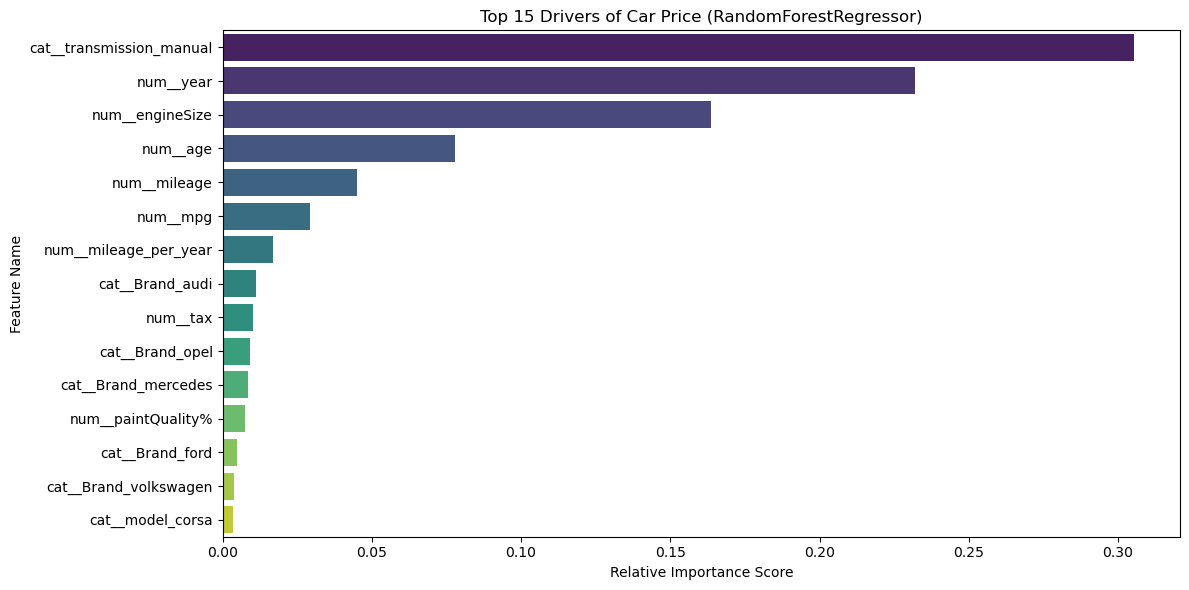


[Generating Predictions on Test Set...]
Success. Predictions saved to 'submission_group34.csv'.
Sample Predictions:
    carID         price
0   89856   9109.566550
1  106581  24418.928879
2   80886  13690.857223
3  100174  16705.700819
4   81376  24225.508379


In [10]:

# 1. Extract Best Model & Performance
best_model = random_search.best_estimator_
best_regressor = best_model.named_steps['regressor']

print("[Winner Identified]")
print(f"Algorithm: {best_regressor.__class__.__name__}")
print(f"Best RMSE (Log Scale): {-random_search.best_score_:.4f}")
print("-" * 30)

# 2. Feature Importance Visualization
# We dynamically extract feature names to handle the pipeline's transformations.

# Check if the winning model supports feature importance (Trees do, Lasso/Ridge use 'coef_')
if hasattr(best_regressor, 'feature_importances_'):
    
    # 1. Get all feature names generated by the Preprocessor (OneHot + Numeric)
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
    
    # 2. Filter names if Feature Selection (SelectKBest) was active
    selector = best_model.named_steps['selector']
    if hasattr(selector, 'get_support'):
        # Keep only the features that survived the selection process
        feature_names = feature_names[selector.get_support()]
    
    # 3. Get the Importance Scores from the Model
    importances = best_regressor.feature_importances_
    
    # 4. Create a DataFrame for visualization
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # 5. Plot Top 15 Drivers
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
    plt.title(f'Top 15 Drivers of Car Price ({best_regressor.__class__.__name__})')
    plt.xlabel('Relative Importance Score')
    plt.ylabel('Feature Name')
    plt.tight_layout()
    plt.show()

elif hasattr(best_regressor, 'coef_'):
    # Fallback for Linear Models (Lasso/Ridge) which use Coefficients
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
    selector = best_model.named_steps['selector']
    if hasattr(selector, 'get_support'):
        feature_names = feature_names[selector.get_support()]
        
    coefs = best_regressor.coef_
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs
    }).sort_values(by='Coefficient', key=abs, ascending=False)
    
    print("Top 10 Coefficients (Absolute Magnitude):")
    display(feat_imp_df.head(10))

# 3. Generalization Check (Submission Generation)
print("\n[Generating Predictions on Test Set...]")

# Predict (Output is in Log-Scale)
log_predictions = best_model.predict(X_test_clean)

# Inverse Transform (Convert Log-Price back to Real Price)
# Formula: exp(prediction) - 1
real_price_predictions = np.expm1(log_predictions)

# Format Submission
submission = pd.DataFrame({
    'carID': test_df['carID'], # Ensure strict ID alignment
    'price': real_price_predictions
})

# Save
submission_filename = 'submission_group34.csv'
submission.to_csv(submission_filename, index=False)

print(f"Success. Predictions saved to '{submission_filename}'.")
print(f"Sample Predictions:\n{submission.head()}")